# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np
import matplotlib.pyplot as plt

Let's get the data!

In [44]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [45]:
# Your code here :
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [46]:
# Your code here :
total_words = len(tokenizer.word_index) + 1
print("total unique words are:", total_words)

total unique words are: 3375


In [47]:
# show 20 most common words and their indices
for w, idx in list(tokenizer.word_index.items())[:20]:
    print(idx, w)

1 and
2 the
3 to
4 of
5 my
6 i
7 in
8 that
9 thy
10 thou
11 with
12 for
13 is
14 not
15 love
16 but
17 a
18 me
19 thee
20 so


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [48]:
# Your code here :
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

In [49]:
print("Total input sequences created:", len(input_sequences))

Total input sequences created: 15484


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [50]:
# Your code here :
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))

print ("Max Sequence Lenght:", max_sequence_len)
print ("Input sequence shape:", input_sequences.shape)

Max Sequence Lenght: 11
Input sequence shape: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [51]:
# Your code here :
predictors, labels = input_sequences[:,:-1], input_sequences[:,-1]

print ("Predictors shape:", predictors.shape)
print ("Labels shape:", labels.shape)

Predictors shape: (15484, 10)
Labels shape: (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [52]:
# Your code here :
labels = ku.to_categorical(labels, num_classes=total_words)

print ("Labels shape:", labels.shape)

Labels shape: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [53]:
#building the model
model = Sequential()

    # embedding layer
    #Converts each word index into a 100-dimensional dense vector representation.
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1))

    #Bidirectional LTSM layer
    #Processes text both forward and backward to better capture context.
model.add(Bidirectional(LSTM(150, return_sequences=True)))

    #Dropout Layer
    #Reduces overfitting by randomly ignoring 20% of neurons during training.
model.add(Dropout(0.2))

    #Second LSTM layer
    #Learns sequential dependencies in the data.
model.add(LSTM(100))

    #intermediate Dense layer with L2 Regularization
    #Adds non-linearity and complexity, with L2 regularization to prevent overfitting.
model.add(Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

    #Output Dense Layer with softmax actiation
    #Outputs probabilities for each possible next word in the vocabulary.
model.add(Dense(total_words, activation='softmax'))



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [54]:
# Your code here :
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [55]:
# Your code here :
print (model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [56]:
# Your code here :
history = model.fit(predictors, labels, epochs=50, verbose=1)

#after running code, accuracy was

Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.0189 - loss: 7.3758
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0227 - loss: 6.4611
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0257 - loss: 6.3932
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0288 - loss: 6.2518
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0308 - loss: 6.1683
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0340 - loss: 6.1127
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0353 - loss: 6.0756
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0409 - loss: 5.9747
Epoch 9/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0447 - loss: 5.9390
Epoch 10/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0469 - loss: 5.8481
Epoch 11/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0540 - loss: 5.7209
Epoch 12/50
484/484 ━━━━━━━━━━━━━━━━━━━━

In [61]:
print (model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,999,463 (76.29 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,332,976 (50.86 MB)

None


# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

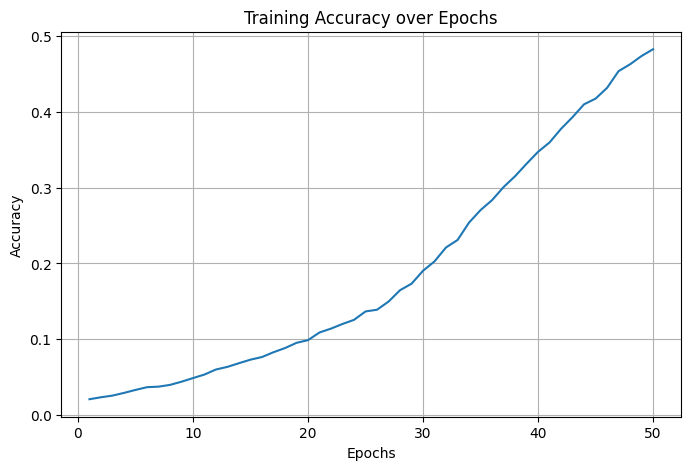

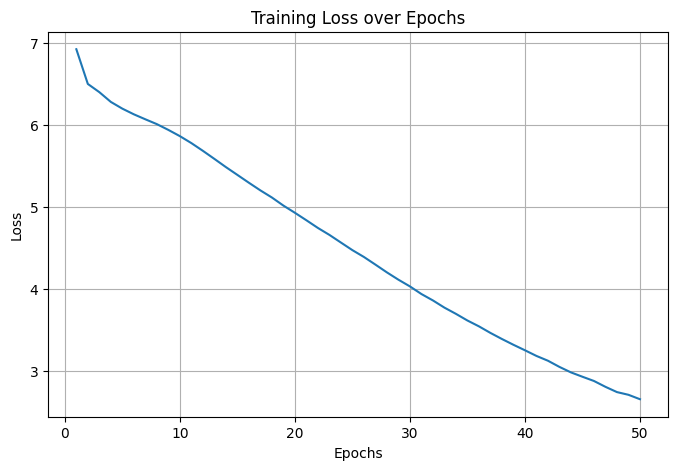

In [63]:
#Training acc and loss:
#get acc and loss from training hist
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

#Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs, acc)
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

#Plot Loss
plt.figure(figsize=(8,5))
plt.plot(epochs, loss)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [62]:
"""
Explanation

history.history is a dictionary containing recorded metrics for each epoch.

history.history['accuracy'] → list of accuracy values per epoch.

history.history['loss'] → list of loss values per epoch.

epochs = range(1, len(acc) + 1) creates a list of epoch numbers for the x-axis.

plt.plot() draws the line graphs.

plt.grid(True) adds gridlines to make the chart easier to read.
"""

"\nExplanation\n\nhistory.history is a dictionary containing recorded metrics for each epoch.\n\nhistory.history['accuracy'] → list of accuracy values per epoch.\n\nhistory.history['loss'] → list of loss values per epoch.\n\nepochs = range(1, len(acc) + 1) creates a list of epoch numbers for the x-axis.\n\nplt.plot() draws the line graphs.\n\nplt.grid(True) adds gridlines to make the chart easier to read.\n"

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [66]:
# Let's go!

seed_text = "I do crave that sugared roundel with such fierce desire, I would sooner lift a banker’s coffer than go without."
next_words = 100

for _ in range(next_words):
    #convert current text to a sequence of int
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #pad to match input length expected by the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    #predict the next word.
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0]
    #find the corresponding word from the tokenizer's index
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    #append the predicted word to the seed text
    seed_text += " " + output_word
print("\nGenerated text:\n")
print(seed_text)


Generated text:

I do crave that sugared roundel with such fierce desire, I would sooner lift a banker’s coffer than go without. 'will' of part out lack of both both time lovely glory to give both decay pain be come more ' lack ' ' to stay a wrong of light quite reap quite gone clearer gone to part thee so so dearer worth it live true face one bring thine much bright and truth ' part to love her face hid of life more woe days ' eye's eyes part love to thee of part thee bright to latch wrong unbred twain clearer twain growing truth of memory love part thee is time in thee forget me worth more grew to


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [67]:
# Repetition :

seed_text = "Dear call your mother"
next_words = 15

for _ in range(next_words):
    #convert current text to a sequence of int
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #pad to match input length expected by the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    #predict the next word.
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0]
    #find the corresponding word from the tokenizer's index
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    #append the predicted word to the seed text
    seed_text += " " + output_word
print("\nGenerated text:\n")
print(seed_text)


Generated text:

Dear call your mother being to stay mine write in part thee it contains live so strong argument friend


Experiment with at least 3 different seed_text strings and see what happens!

In [68]:
# Your code here :
#Dear call your mother being to stay mine write in part thee it contains live so strong argument friend

# Repetition :

seed_text = "Dear call your mother being to stay mine write in part thee it contains live so strong argument friend"
next_words = 5

for _ in range(next_words):
    #convert current text to a sequence of int
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #pad to match input length expected by the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    #predict the next word.
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0]
    #find the corresponding word from the tokenizer's index
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    #append the predicted word to the seed text
    seed_text += " " + output_word
print("\nGenerated text:\n")
print(seed_text)


Generated text:

Dear call your mother being to stay mine write in part thee it contains live so strong argument friend of wrong ' clearer burn


In [70]:
# Repetition :

seed_text = "Shall I kiss thee frog in hopes of such creature to turn in a princess"
next_words = 45

for _ in range(next_words):
    #convert current text to a sequence of int
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #pad to match input length expected by the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    #predict the next word.
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0]
    #find the corresponding word from the tokenizer's index
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    #append the predicted word to the seed text
    seed_text += " " + output_word
print("\nGenerated text:\n")
print(seed_text)


Generated text:

Shall I kiss thee frog in hopes of such creature to turn in a princess view of ill words of wrong ' torn ' lack of all thee days lies part to write in thee thee so dearer heart new strong cause of wrong ' used defaced befits growing friend of thee is part my heart sheds show me still


In [ ]:
# Repetition :

seed_text = "Your mother is so fat that"
next_words = 45

for _ in range(next_words):
    #convert current text to a sequence of int
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #pad to match input length expected by the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    #predict the next word.
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)[0]
    #find the corresponding word from the tokenizer's index
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    #append the predicted word to the seed text
    seed_text += " " + output_word
print("\nGenerated text:\n")
print(seed_text)


Generated text:

Your mother is so fat that thou wilt tend old face old blot it heart on you ' lack new strong lack to ill ill love of thee long truth ' made of woe sight ' ' ' of part thee of of of part bright art wrong ' lack '
